## PFDA Project - Contact Center Performance Analysis
by David O'Sullivan

## 1. Introduction

This notebook contains my analysis of PWCs contact centre data. The goal of the notebook is to analyse KPI's, spot trends and find ways to improve performance overall. The text in this notebook will be kept to a minimum as requested however some sections are more complex than others and require detailed explanations.

In [37]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading from MySQL

The code below is used to connect to a database I created in MySQL. As this is a public notebook I created a config file containing any sensitive information. I was unable to find a config file so created one within my terminal via bash scripts.

The next step was using mysql.connector.connect to establish a connection to the MySQL database. This was the most straightforawd step as we did this during the semester. As I only needed to run one straightforward query there was no need to create a cursor. Instead I defined the query and ran it with the connection to load it into the pandas dataframe (df = pd.read_sql(query, connection))

When originally running the code everything looked okay except for the time column. This was coming up as "0 days" followed by the time. I decided the best way to handle this was to use lambda to convert the column to a string and then slice it to only show the time section of the rows [7:15], excluding "0 Days". I'd be unable to analyse the data properly with time as a string so dt.time is used in the data preperation section to rectify this.

Refs:

Create INI config file : https://www.quora.com/How-do-you-create-an-INI-config-file

Connecting MySQL Using Connector : https://dev.mysql.com/doc/connector-python/en/connector-python-example-connecting.html

pd.read_sql : https://blog.panoply.io/how-to-read-a-sql-query-into-a-pandas-dataframe

lambda to change data type : https://stackoverflow.com/questions/51341532/want-to-use-a-lambda-function-to-change-the-type-of-a-cell-if-it-is-type-float



In [99]:
import mysql.connector
from configparser import ConfigParser

# Define the path to config file
config_path = '/Users/davidosullivan/Documents/my_project/config_files/config.ini'

# Read the config.ini file
config = ConfigParser()
config.read(config_path)

# Retrieve the database connection details
host = config.get('mysql', 'host')
user = config.get('mysql', 'user')
password = config.get('mysql', 'password')
database = config.get('mysql', 'database')

# Connect to the database
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# Query to retrieve all data
query = "SELECT * FROM call_data"

# Load the data into a pandas DataFrame
df = pd.read_sql(query, connection)

# Close the connection to the database
connection.close()

# Convert the 'time' column to a string in the format HH:MM:SS (Removing the unneccessary sting data 0:7)
df['time'] = df['time'].apply(lambda x: str(x)[7:15])

df.head()


/var/folders/0d/mbrvmyx10n92tdtbjzgv0tjm0000gn/T/ipykernel_51527/3994963931.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,call_id,agent,date,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating
0,ID0001,Diane,2021-01-01,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0
1,ID0002,Becky,2021-01-01,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0
2,ID0003,Stewart,2021-01-01,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0
3,ID0004,Greg,2021-01-01,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0
4,ID0005,Becky,2021-01-01,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0


## 2. Data Preperation

In [100]:
# Set Index
df.set_index('date', inplace=True)
df.head()

,call_id,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating
date,,,,,,,,,
2021-01-01,ID0001,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0
2021-01-01,ID0002,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0
2021-01-01,ID0003,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0
2021-01-01,ID0004,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0
2021-01-01,ID0005,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0


Additional column converting average talk duration from minutes to seconds is needed for future analysis.

Refs:

https://stackoverflow.com/questions/5522031/convert-timedelta-to-total-seconds

https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.total_seconds.html

In [102]:
# Ensure 'AvgTalkDuration' is in string format
df['avg_talk_duration'] = df['avg_talk_duration'].astype(str)

# Convert 'AvgTalkDuration' to seconds
df['avg_talk_duration_seconds'] = pd.to_timedelta(df['avg_talk_duration']).dt.total_seconds()


In [103]:
# Check are there null values to deal with
df.isnull().sum()

call_id                         0
agent                           0
time                            0
topic                           0
answered                        0
resolved                        0
speed_of_answer_in_seconds      0
avg_talk_duration               0
satisfaction_rating             1
avg_talk_duration_seconds     946
dtype: int64

In [104]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

0

In [105]:
# Drop Irrelevant Columns
df = df.drop(columns=['call_id'])
df.head()

,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating,avg_talk_duration_seconds
date,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0,143.0
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0,242.0
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0,131.0
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0,37.0
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0,60.0


An additional column putting time of day into categories is needed for future analysis. This is done by combining pandas datetime function with IF, ELIF and ELSE statements.

Refs:

https://stackoverflow.com/questions/32375471/pandas-convert-strings-to-time-without-date


https://stackoverflow.com/questions/32113707/how-would-i-put-an-if-statement-inside-a-function

In [106]:
# Ensure in datetime format
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

# Define a function to categorize the time
def categorise_time(time):
    if time >= pd.to_datetime('09:00:00').time() and time < pd.to_datetime('12:00:00').time():
        return 'Morning'
    elif time >= pd.to_datetime('12:00:00').time() and time < pd.to_datetime('15:00:00').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('15:00:00').time() and time < pd.to_datetime('18:00:00').time():
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new column
df['time_of_day_category'] = df['time'].apply(categorise_time)

# Display the first row to ensure the categorization
df.head(1)


,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating,avg_talk_duration_seconds,time_of_day_category
date,,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0,143.0,Morning


In [242]:
df['avg_talk_duration_seconds'].describe()

count    4054.000000
mean      224.922792
std       111.381555
min        30.000000
25%       130.000000
50%       226.000000
75%       319.000000
max       420.000000
Name: avg_talk_duration_seconds, dtype: float64

## Section 2 - EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2021-01-01 to 2021-03-31
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   agent                       5000 non-null   object 
 1   time                        5000 non-null   object 
 2   topic                       5000 non-null   object 
 3   answered (y/n)              5000 non-null   object 
 4   resolved                    5000 non-null   object 
 5   speed of answer in seconds  4054 non-null   float64
 6   avgtalkduration             5000 non-null   object 
 7   satisfaction rating         4054 non-null   float64
 8   avgtalkduration_seconds     4054 non-null   float64
 9   time_of_day_category        5000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 429.7+ KB


In [ ]:
df.describe()

,speed of answer in seconds,satisfaction rating,avgtalkduration_seconds
count,4054.000000,4054.000000,4054.000000
mean,67.520720,3.403552,224.922792
std,33.592872,1.212220,111.381555
min,10.000000,1.000000,30.000000
25%,39.000000,3.000000,130.000000
50%,68.000000,3.000000,226.000000
75%,97.000000,4.000000,319.000000
max,125.000000,5.000000,420.000000


In [ ]:
# Compute the correlation matrix 
columns_to_correlate = ['speed of answer in seconds','avgtalkduration_seconds', 'satisfaction rating']
correlation_matrix = df[columns_to_correlate].corr()
correlation_matrix

,speed of answer in seconds,avgtalkduration_seconds,satisfaction rating
speed of answer in seconds,1.000000,-0.002898,0.000952
avgtalkduration_seconds,-0.002898,1.000000,0.000143
satisfaction rating,0.000952,0.000143,1.000000


In [75]:
df.head()

,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating,avg_talk_duration_seconds,time_of_day_category
date,,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0,143.0,Morning
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0,242.0,Morning
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0,131.0,Morning
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0,37.0,Morning
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0,60.0,Morning


In [107]:
df.head()

,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating,avg_talk_duration_seconds,time_of_day_category
date,,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0,143.0,Morning
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0,242.0,Morning
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0,131.0,Morning
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0,37.0,Morning
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0,60.0,Morning


Boxplot Ref : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

<Figure size 1000x600 with 0 Axes>

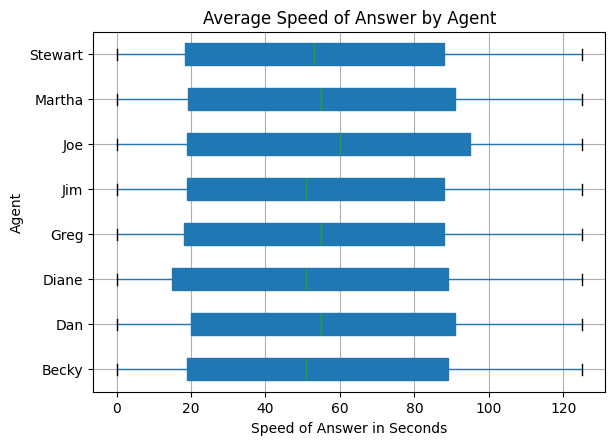

In [121]:
plt.figure(figsize=(10, 6))
df.boxplot(column='speed_of_answer_in_seconds', by='agent', vert=False, patch_artist=True)
plt.title('Average Speed of Answer by Agent')
plt.suptitle('')
plt.xlabel('Speed of Answer in Seconds')
plt.ylabel('Agent')
plt.show()


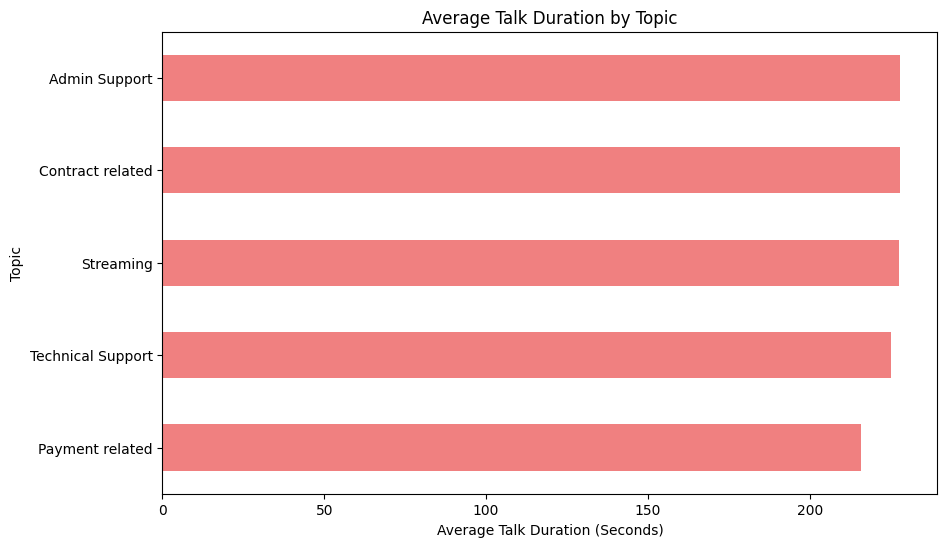

In [186]:
plt.figure(figsize=(10, 6))
df.groupby('topic')['avg_talk_duration_seconds'].mean().sort_values().plot(kind='barh', color='lightcoral')
plt.title('Average Talk Duration by Topic')
plt.xlabel('Average Talk Duration (Seconds)')
plt.ylabel('Topic')
plt.show()


Pie Chart Refs: 

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html

https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct

/var/folders/0d/mbrvmyx10n92tdtbjzgv0tjm0000gn/T/ipykernel_51527/1608978780.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unresolved_calls['unresolved_due_to_no_answer'] = unresolved_calls['answered'] == 'N'


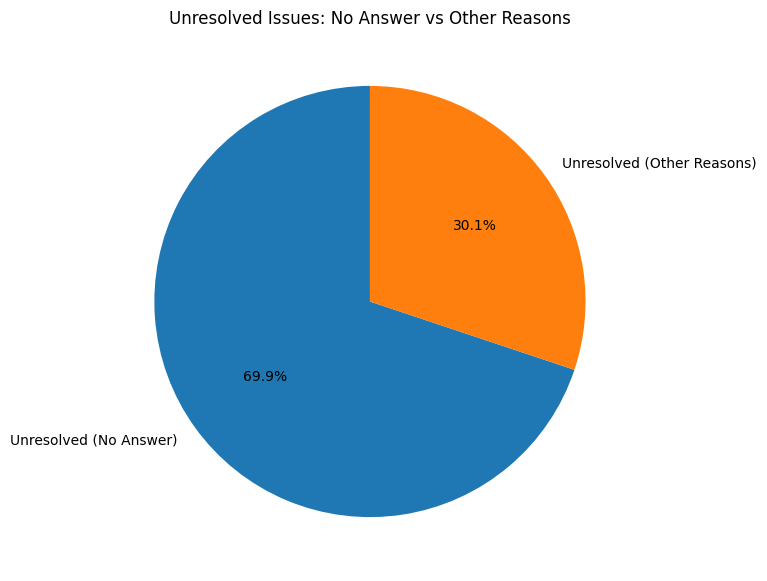

In [284]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for unresolved calls (resolved == 'N')
unresolved_calls = df[df['resolved'] == 'N']

# Create a column to track unresolved issues due to calls not being answered
unresolved_calls['unresolved_due_to_no_answer'] = unresolved_calls['answered'] == 'N'

# Count unresolved calls due to no answer vs other reasons
unresolved_counts = unresolved_calls['unresolved_due_to_no_answer'].value_counts()

# Map True/False to labels
labels = ['Unresolved (No Answer)', 'Unresolved (Other Reasons)']

# Ensure the order matches labels
values = [unresolved_counts[True], unresolved_counts[False]]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(values, labels=labels, autopct='%.1f%%', startangle=90)
plt.title('Unresolved Issues: No Answer vs Other Reasons')
plt.show()


Plot Refs:

https://stackoverflow.com/questions/46992158/unable-to-resample-then-plot-a-pandas-data-frame

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

https://www.geeksforgeeks.org/python-pandas-dataframe-resample/

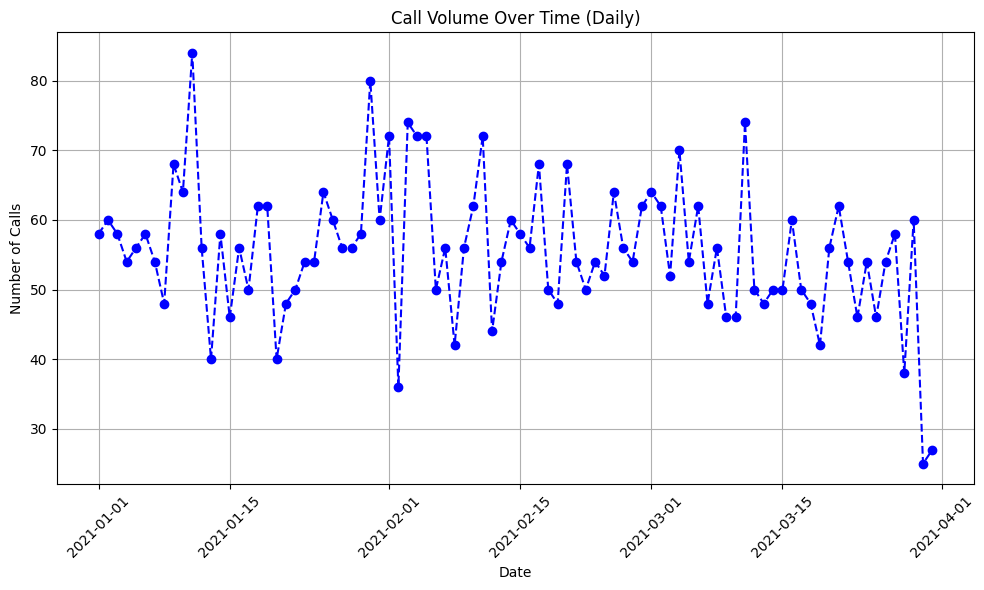

In [170]:
# Resample the data by days ('D') & use .size() to count the values
call_volume_daily = df.resample('D').size() 

# Plot the call volume over time (daily)
plt.figure(figsize=(10, 6))
plt.plot(call_volume_daily.index, call_volume_daily.values, marker='o', linestyle='--', color='b')
plt.title('Call Volume Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.axhline ref: https://www.geeksforgeeks.org/matplotlib-axes-axes-axhline-in-python/

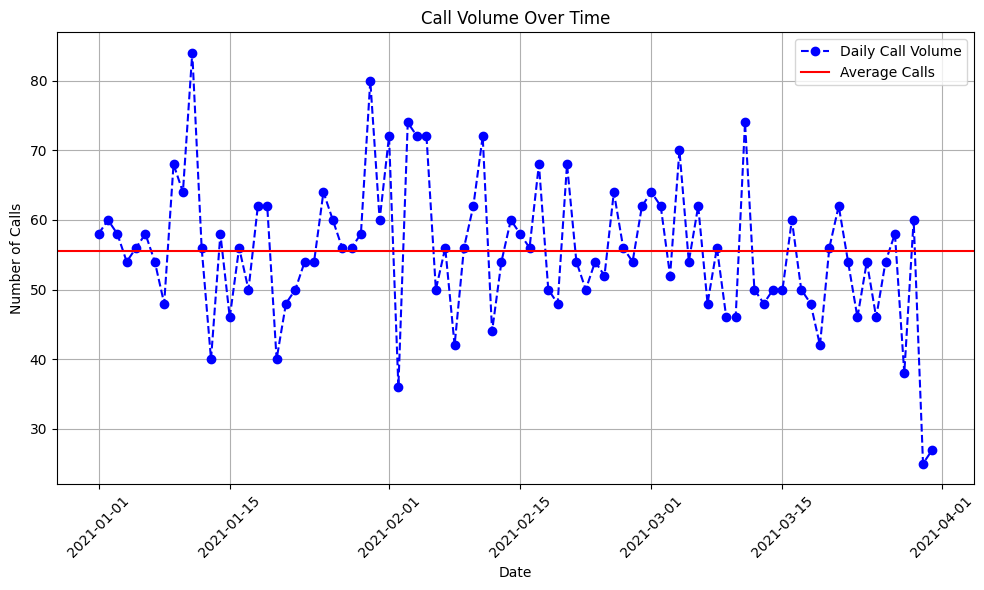

In [238]:
# Resample the data by day ('D') & use .size() to count the values
call_volume_daily = df.resample('d').size()

# Calculate the average call volume
average_calls = call_volume_daily.mean()

# Plot the call volume over time (daily)
plt.figure(figsize=(10, 6))
plt.plot(call_volume_daily.index, call_volume_daily.values, marker='o', linestyle='--', color='b', label='Daily Call Volume')
plt.axhline(y=average_calls, color='r', linestyle='-', label='Average Calls')
plt.title('Call Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## KPI Analysis 

#### 1) Operational Efficiency 

#### (i) Average Call Duration

For call duration it is very consistent across both topics and agents. The average call lasts 225 seconds. Each agent and topics average is within 10 seconds of the overall call average. When diving deeper into the data grouping agent and topic together there are some combinations where Agents handling time is above average but not by a worrying amount.

In [206]:
avg_call_duration = df['avg_talk_duration_seconds'].mean().round()
avg_call_duration

225.0

In [203]:
agent_avg_duration = df.groupby('agent')['avg_talk_duration_seconds'].mean().round()

agent_avg_duration


agent
Becky      220.0
Dan        231.0
Diane      219.0
Greg       227.0
Jim        228.0
Joe        224.0
Martha     224.0
Stewart    226.0
Name: avg_talk_duration_seconds, dtype: float64

In [204]:
topic_avg_duration = df.groupby('topic')['avg_talk_duration_seconds'].mean().round()

topic_avg_duration

topic
Admin Support        228.0
Contract related     228.0
Payment related      216.0
Streaming            228.0
Technical Support    225.0
Name: avg_talk_duration_seconds, dtype: float64

In [264]:
# Group by agent and topic & calculate the mean handling time
agent_topic_avg = df.groupby(['agent', 'topic'])['avg_talk_duration_seconds'].mean().reset_index()

# Filter combinations where the average handling time is greater than 260 seconds
high_handling_time = agent_topic_avg[agent_topic_avg['avg_talk_duration_seconds'] > 225]

high_handling_time = high_handling_time.sort_values('avg_talk_duration_seconds', ascending=False)
# Display the results
print("Combinations of Agent and Topic with Average Handling Time > 225 seconds:")
print(high_handling_time)


Combinations of Agent and Topic with Average Handling Time > 225 seconds:
      agent              topic  avg_talk_duration_seconds
18     Greg          Streaming                 247.864865
16     Greg   Contract related                 246.888889
7       Dan    Payment related                 240.933962
35  Stewart      Admin Support                 240.648936
23      Jim          Streaming                 237.607843
21      Jim   Contract related                 236.157025
19     Greg  Technical Support                 234.911111
25      Joe      Admin Support                 231.913978
38  Stewart          Streaming                 231.542169
20      Jim      Admin Support                 231.000000
5       Dan      Admin Support                 230.528736
34   Martha  Technical Support                 230.156863
28      Joe          Streaming                 229.933333
11    Diane   Contract related                 229.684783
9       Dan  Technical Support                 228.80869

In [227]:
outliers = df[df['avg_talk_duration_seconds'] > df['avg_talk_duration_seconds'].quantile(0.95)]

# Frequency analysis for agents
agent_outlier_counts = outliers['agent'].value_counts()

# Frequency analysis for topics
topic_outlier_counts = outliers['topic'].value_counts()

# Display results
print("Agents most frequently in outliers:")
print(agent_outlier_counts)

print("\nTopics most frequently in outliers:")
print(topic_outlier_counts)

Agents most frequently in outliers:
agent
Dan        34
Diane      26
Stewart    24
Becky      24
Greg       23
Martha     22
Joe        21
Jim        21
Name: count, dtype: int64

Topics most frequently in outliers:
topic
Contract related     44
Streaming            44
Payment related      42
Admin Support        34
Technical Support    31
Name: count, dtype: int64


In [221]:
# Group by agent and topic, and count the occurrences
agent_topic_counts = outliers.groupby(['agent', 'topic']).size().reset_index(name='count')

# Sort by the count in descending order
agent_topic_counts_sorted = agent_topic_counts.sort_values(by='count', ascending=False)

agent_topic_counts_sorted.head(10)

,agent,topic,count
7,Dan,Payment related,11
21,Jim,Contract related,9
36,Stewart,Contract related,9
8,Dan,Streaming,8
2,Becky,Payment related,8
10,Diane,Admin Support,8
29,Joe,Technical Support,7
1,Becky,Contract related,6
9,Dan,Technical Support,6
28,Joe,Streaming,6


In [240]:
# Group by Agent and Topic & Calculate the average
grouped_avg_duration = df.groupby(['agent', 'topic'])['avg_talk_duration_seconds'].mean()

# Compare each groups average with overall average 
above_avg_handling_time = grouped_avg_duration[grouped_avg_duration > 240]

above_avg_handling_time


agent    topic           
Dan      Payment related     240.933962
Greg     Contract related    246.888889
         Streaming           247.864865
Stewart  Admin Support       240.648936
Name: avg_talk_duration_seconds, dtype: float64

#### (ii) Resolution Rate

For reference, first visual below is from the EDA section. This visual is very insightful showing nearly 70% of unresolved issues are due to unanaswered calls. The total number of unresolved issues is 1354. With an average resolution rate of 73%, if calls were being answered then the likihood is that the number of unresolved issues would be much lower, ultimately leading to a better customer experience. Looking at the correlation of call volume and volume of unanswered calls there is a strong positive relationship. This combined with a 70%+ resolution rate indicates that the solution to improving the resolution rate would be additional staff. The current number of employees are unable to deal with call volumes during peak periods.

/var/folders/0d/mbrvmyx10n92tdtbjzgv0tjm0000gn/T/ipykernel_51527/1608978780.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unresolved_calls['unresolved_due_to_no_answer'] = unresolved_calls['answered'] == 'N'


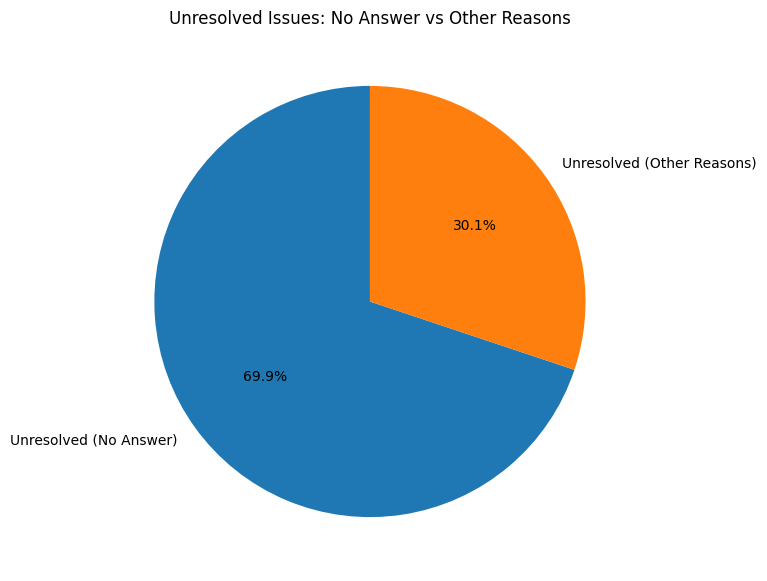

In [281]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for unresolved calls (resolved == 'N')
unresolved_calls = df[df['resolved'] == 'N']

# Create a column to track unresolved issues due to calls not being answered
unresolved_calls['unresolved_due_to_no_answer'] = unresolved_calls['answered'] == 'N'

# Count unresolved calls due to no answer vs other reasons
unresolved_counts = unresolved_calls['unresolved_due_to_no_answer'].value_counts()

# Map True/False to labels
labels = ['Unresolved (No Answer)', 'Unresolved (Other Reasons)']

# Ensure the order matches labels
values = [unresolved_counts[True], unresolved_counts[False]]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(values, labels=labels, autopct='%.1f%%', startangle=90)
plt.title('Unresolved Issues: No Answer vs Other Reasons')
plt.show()


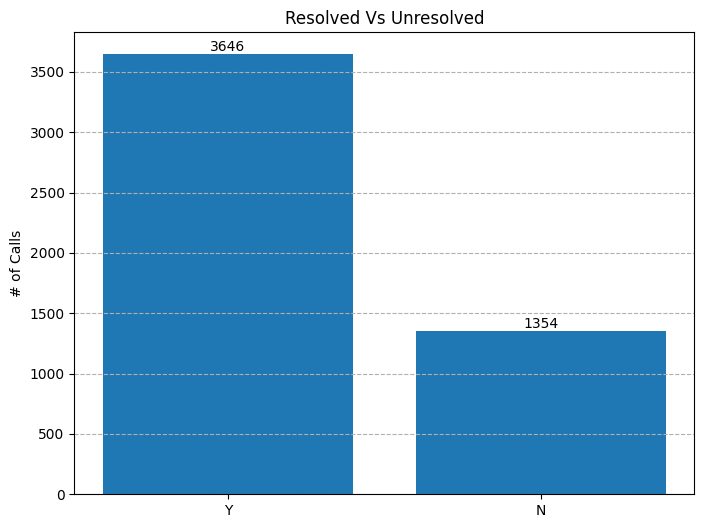

In [274]:
counts = df['resolved'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(counts.index, counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('Resolved Vs Unresolved')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.show()

In [275]:
# Calculate total issues
total_issues = df['resolved'].count()

# Count resolved issues
resolved_issues = (df['resolved'] == 'Y').sum()

# Calculate the percentage
percentage_resolved = (resolved_issues / total_issues) * 100

(f"Percentage of resolved issues: {percentage_resolved:.0f}%")

'Percentage of resolved issues: 73%'

In [288]:
# Calculate resolution rates by topic
resolution_by_topic = df.groupby('topic')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Calculate resolution rates by agent
resolution_by_agent = df.groupby('agent')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Display insights
print("Resolution Rate by Topic:\n", resolution_by_topic)
print("\nResolution Rate by Agent:\n", resolution_by_agent)


Resolution Rate by Topic:
 topic
Admin Support        74.1
Contract related     72.6
Payment related      72.4
Streaming            73.3
Technical Support    72.2
Name: resolved, dtype: float64

Resolution Rate by Agent:
 agent
Becky      73.2
Dan        74.4
Diane      71.4
Greg       72.9
Jim        72.8
Joe        73.5
Martha     72.3
Stewart    72.9
Name: resolved, dtype: float64


In [289]:
# Group data by time of day to calculate total and unanswered calls
time_of_day_summary = df.groupby('time_of_day_category').agg(total_calls=('answered', 'count'),unanswered_calls=('answered', lambda x: (x == 'N').sum()))

# Compute correlation
correlation_time_of_day = time_of_day_summary['total_calls'].corr(time_of_day_summary['unanswered_calls']).round(5)

print("Correlation between total calls and unanswered calls by time of day:", correlation_time_of_day)


Correlation between total calls and unanswered calls by time of day: 0.9988


#### 2) Customer Satisfaction - Satisfaction Rating & Resolved Vs Unresolved

Unresolved caused by unanaswered calls 

Review satisfaction scores and exclude unanswered calls


#### 3) Agent Performance - Resolution Rate, Satisfaction Rate & Call Volume Handled


## Advanced Plots - Interactive Visuals

## Insights and Recommendations

## Resolution Rate & Unanswered Calls

#### Unanswered Calls by Agent & Time of Day - Over 50% of unanswered calls are in the afternoon

In [80]:
# Unanswered call rate by agent
unanswered_by_agent = df[df['answered'] == 'N'].groupby('agent').size()

# Unanswered call rate by time of day
unanswered_by_time = df[df['answered'] == 'N'].groupby('time_of_day_category').size()

# Display insights
print("Unanswered Calls by Agent:\n", unanswered_by_agent)
print("\nUnanswered Calls by Time of Day:\n", unanswered_by_time)


Unanswered Calls by Agent:
 agent
Becky      114
Dan        110
Diane      132
Greg       122
Jim        130
Joe        109
Martha     124
Stewart    105
dtype: int64

Unanswered Calls by Time of Day:
 time_of_day_category
Afternoon    319
Evening      308
Morning      317
Night          2
dtype: int64


## Unanswered Calls - Root Cause Analysis

#### Correlation 

In [271]:
# Group data by time of day to calculate total and unanswered calls
time_of_day_summary = df.groupby('time_of_day_category').agg(total_calls=('answered', 'count'),unanswered_calls=('answered', lambda x: (x == 'N').sum()))

# Compute correlation
correlation_time_of_day = time_of_day_summary['total_calls'].corr(time_of_day_summary['unanswered_calls']).round(5)

print("Correlation between total calls and unanswered calls by time of day:", correlation_time_of_day)


Correlation between total calls and unanswered calls by time of day: 0.9988


The below analysis shows that there is close to no relationship between speed of answer and resolved issues as well as call duration and satisfaction rating.

#### Refs:
lambda w/ if statement : https://stackoverflow.com/questions/1585322/is-there-a-way-to-perform-if-in-pythons-lambda

In [88]:
# Correlation between speed of answer and resolution rate
df['resolved_numeric'] = df['resolved'].apply(lambda x: 1 if x == 'Y' else 0)
correlation_speed_resolution = df['speed_of_answer_in_seconds'].corr(df['resolved_numeric']).round(5)

# Correlation between satisfaction and talk duration
correlation_satisfaction_duration = df['avg_talk_duration_seconds'].corr(df['satisfaction_rating']).round(5)


print("Correlation between speed of answer and resolved issues:", correlation_speed_resolution)
print("Correlation between call duration and satisfaction rating:", correlation_satisfaction_duration)



Correlation between speed of answer and resolved issues: 0.52498
Correlation between call duration and satisfaction rating: 0.00014


## Predictive Analysis - What do the future numbers of unanswered calls look like?


#### References


#### Reminder 

- Check afternoon resolution rate
- Are there certain days where individual employees rack up most of their unanswered calls?

## Business Insights Part 2 - Customer Satisfaction



#### References



#### Satisfaction by Resolution Status, Topic, Call Duration & Time of Day

** Key Callout here is that even when issues aren't resolved the average satisfaction score is still greater than the score where issues are resolved.

In [285]:
# Satisfaction by resolution status
satisfaction_by_resolution = df.groupby('resolved')['satisfaction_rating'].mean()

# Satisfaction by topic
satisfaction_by_topic = df.groupby('topic')['satisfaction_rating'].mean()

# Satisfaction by call duration
satisfaction_by_duration = df['avg_talk_duration_seconds'].corr(df['satisfaction_rating'])

# Satisfaction by Time of Day
satisfaction_by_time = df.groupby('time_of_day_category')['satisfaction_rating'].mean()

print("Satisfaction by Resolution:\n", satisfaction_by_resolution)
print("\nSatisfaction by Topic:\n", satisfaction_by_topic)
print(f"\nCorrelation between Call Duration and Satisfaction: {satisfaction_by_duration:.2f}")
print("Satisfaction By Time of Day:\n", satisfaction_by_time )


Satisfaction by Resolution:
 resolved
N    1.033999
Y    3.400713
Name: satisfaction_rating, dtype: float64

Satisfaction by Topic:
 topic
Admin Support        2.790984
Contract related     2.733333
Payment related      2.758689
Streaming            2.819961
Technical Support    2.697743
Name: satisfaction_rating, dtype: float64

Correlation between Call Duration and Satisfaction: 0.00
Satisfaction By Time of Day:
 time_of_day_category
Afternoon    2.695732
Evening      2.768314
Morning      2.812725
Night        3.071429
Name: satisfaction_rating, dtype: float64


Plot Refs:

https://stackoverflow.com/questions/46992158/unable-to-resample-then-plot-a-pandas-data-frame

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

https://www.geeksforgeeks.org/python-pandas-dataframe-resample/

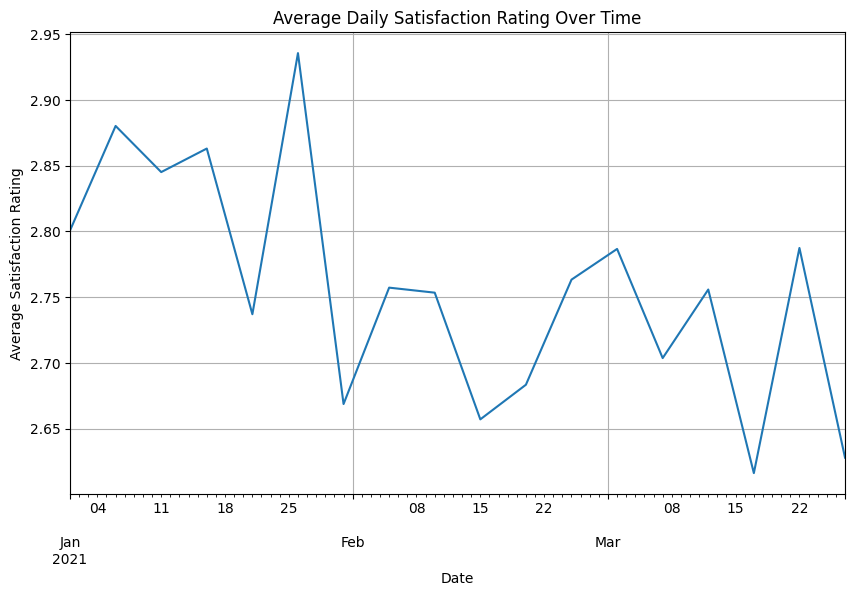

In [158]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the index is of datetime type
df.index = pd.to_datetime(df.index)

# Resample the data to calculate the daily mean 
daily_average = df['satisfaction_rating'].resample('5D').mean()

# Plotting and title
daily_average.plot(kind='line', figsize=(10, 6), title="Average Daily Satisfaction Rating Over Time")

# Adding labels
plt.xlabel("Date")
plt.ylabel("Average Satisfaction Rating")
plt.grid(True)

# Display the plot
plt.show()
